_Version log: Branch of V19. Optimisation using MCMC Metropolis._

In [1]:
import sys, time
import numpy as np
import CS_functions as cs
from matplotlib import pyplot as plt, patches as patches
from scipy import fft as spfft
from tqdm import tqdm

plt.rcParams.update({'font.size':24, 'image.origin': 'lower', 'xtick.minor.visible': True, 'ytick.minor.visible': True, 'lines.linewidth': 2.4, 'figure.facecolor': 'none', 'axes.facecolor': 'white'})
np.set_printoptions(threshold=sys.maxsize)

In [2]:
file_number = 32
file_name = "1dmockanderrors{:d}".format(file_number)
#file_name = "240802134128_altered1d"
file_type = ".csv"

target, uncertainties = cs.open_dataset(file_name, ".csv")
training = np.copy(target) # file 32 has no noise
optlocs_file = "data\\" + file_name +"_optlocs.csv"

In [3]:
reduced_points = 50
regularization_coeffient = 1e-2 # DECREASE FOR COMPLEX IMAGES (up to 1e-7 (floating point error?)) INCREASE FOR SIMPLE IMAGES (up to 1e-2)
idx = np.arange(len(target))

In [4]:
start_time = time.time()

detectors = np.array([], dtype= int)

new_detector = np.argmax(np.abs(target)) # Without any samples, CS cannot find any frequencies so all amplitudes will go to zero. DP wants to locate the point that is furthest away from this zero line. Hence, this is a sensible way to intitalise the loop.
detectors = np.append(detectors, new_detector)

for n in range(1,reduced_points):
    samples = np.full_like(target, np.nan)
    samples[detectors] = target[detectors]
    result = cs.compressed_sensing(samples, regularization_coeffient, ignore_mean= False, dct_type= 1, norm= "ortho")

    new_detector = np.argsort(np.abs(target -result))[::-1] # argsort sorts from smallest to largest but I want largest to smallest
    new_detector = np.setdiff1d(new_detector, detectors, assume_unique= True)[0] # pick the first (largest) item
    detectors = np.append(detectors, new_detector)

samples = np.full_like(target, np.nan)
samples[detectors] = target[detectors]
result = cs.compressed_sensing(samples, regularization_coeffient, ignore_mean= False, dct_type= 1, norm= "ortho")

end_time = time.time()
print(end_time -start_time)

0.02777719497680664


In [5]:
samples = np.full_like(target, np.nan)
samples[detectors] = target[detectors]
result = cs.compressed_sensing(samples, regularization_coeffient, norm= "ortho")
score = cs.evaluate_score(detectors, target, uncertainties, regularization_coeffient= regularization_coeffient, error_type= "L2")

cs.append_array_to_csv(detectors, optlocs_file)
print(score)

WARNING! Noiseless data not provided, assuming interferogram has no noise.
0.033009323049662184


## FWHM graph

In [6]:
regularization_coeffient = 1e-2
max_samples = 30
sample_step = 1
samples = np.arange(sample_step, max_samples, sample_step)

array_length = 50
pixel_pitch = 1.0e-3
FWHM_step = 10e9
FWHMs = np.arange(70e9, 0.4e12, FWHM_step)
central_freq = 300e9
theta = 6.0
examples = {"FWHM": [80e9, 250e9, 80e9], "samples": [10, 10, 5], "measurements": [None, None, None], "detectors": [None, None, None], "target": [None, None, None]}

scores = np.full((len(samples), len(FWHMs)), np.nan)
displacement = np.arange(-(array_length//2), (array_length+1)//2) *pixel_pitch*1e3 #mm

for m, FWHM in tqdm(enumerate(FWHMs)):
    interferogram = cs.generate_interferogram(array_length, pixel_pitch, central_freq, FWHM, theta)
    uncertainty = np.ones_like(interferogram)
    training = np.copy(interferogram) # the interferogram has no noise

    # detectors, _ = cs.douglas_peucker(max_samples, interferogram, uncertainty, regularization_coeffient= regularization_coeffient)

    for n, number_of_samples in enumerate(samples):
        detectors, scores[n, m] = cs.MCMC_metropolis(number_of_samples, interferogram, uncertainty, training, regularization_coeffient, error_type= "L2", iterations= 5000) # hella slow
        # scores[n, m] = cs.evaluate_score(detectors[:number_of_samples], interferogram, uncertainty, regularization_coeffient= regularization_coeffient, domain= "IDCT")

        if number_of_samples in examples["samples"]:
            for i in range(len(examples["FWHM"])):
                if FWHM == examples["FWHM"][i]:
                    examples["detectors"][i] = detectors[:examples["samples"][i]]
                    examples["target"][i] = interferogram.copy()
                    sample = np.full_like(interferogram, np.nan)
                    sample[examples["detectors"][i]] = interferogram[examples["detectors"][i]]
                    examples["measurements"][i] = sample.copy()
                    print("Example {0:d} saved.".format(i+1))

1it [01:25, 85.23s/it]

Example 1 saved.
Example 3 saved.
Example 1 saved.
Example 3 saved.


18it [28:37, 100.35s/it]

Example 2 saved.
Example 2 saved.


33it [54:16, 98.67s/it] 


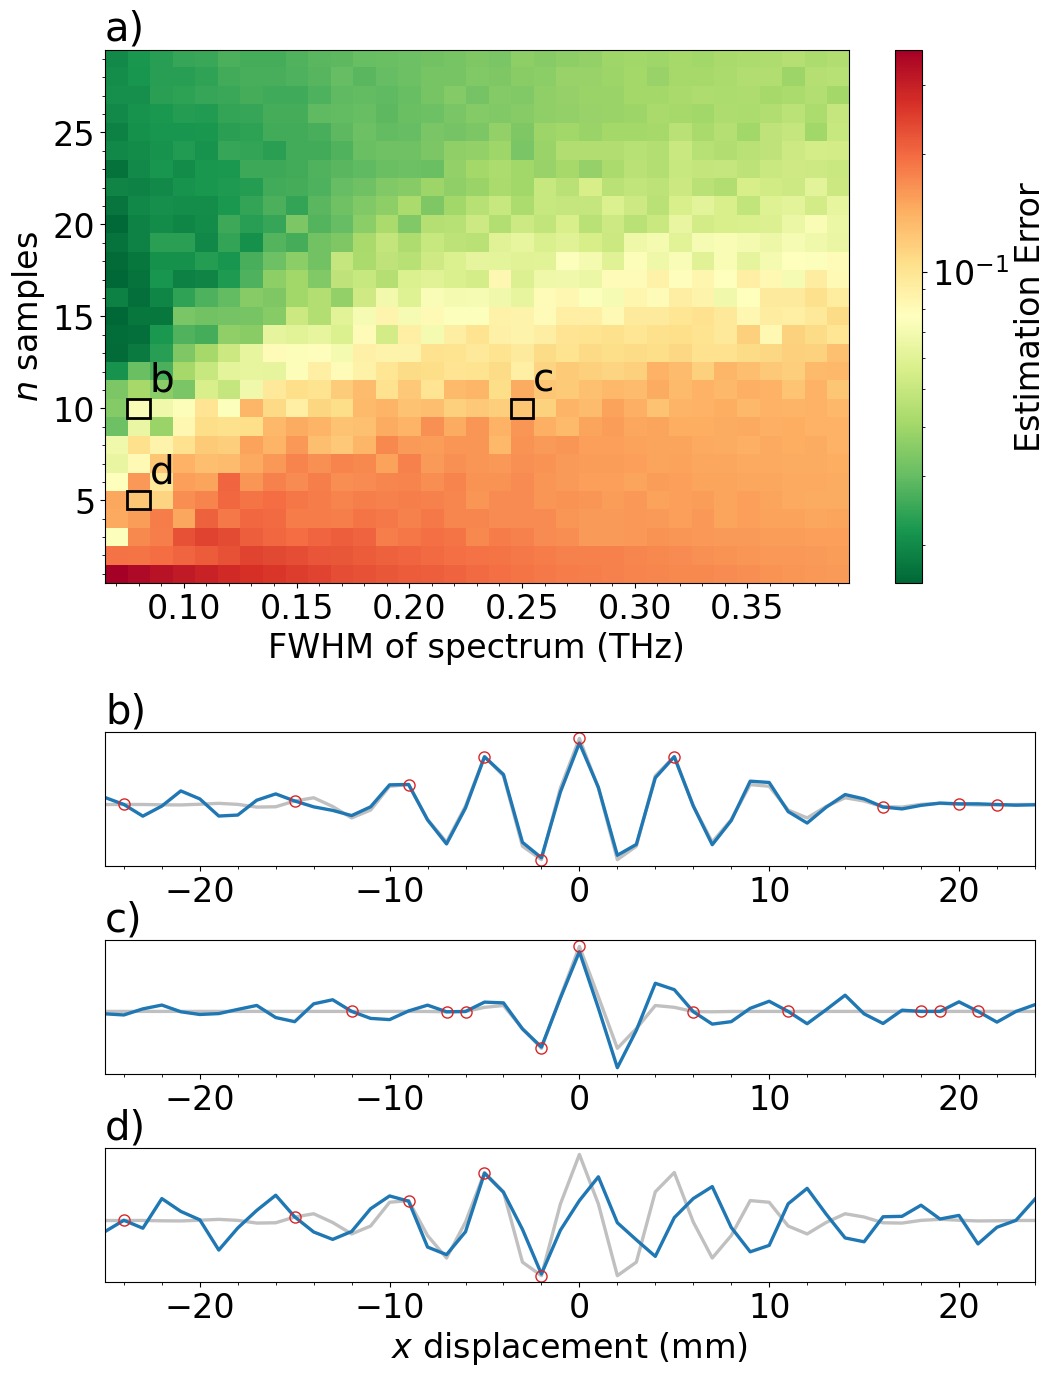

In [7]:
fig, axs = plt.subplots(5, 1, figsize= (12, 16), gridspec_kw= {'height_ratios': [4, 0, 1, 1, 1], "hspace": 0.4})

im = axs[0].imshow(scores,
                   aspect= "auto",
                   interpolation= "none",
                   norm= "log",
                   cmap= "RdYlGn_r",
                   extent= ((1.5*FWHMs[0]-0.5*FWHMs[1]) *1e-12, (1.5*FWHMs[-1]-0.5*FWHMs[-2]) *1e-12, sample_step/2, max_samples -sample_step/2))

axs[0].set(xlabel= "FWHM of spectrum (THz)", ylabel= "$n$ samples")
axs[0].set_title(r"a)", loc= "left")

boxes = [patches.Rectangle(((examples["FWHM"][i]-FWHM_step/2)*1e-12, examples["samples"][i] -0.5), FWHM_step*1e-12, 1, color= "k", linewidth= 2.0, fill= False) for i in range(len(examples["FWHM"]))]
[axs[0].add_patch(box) for box in boxes]
[axs[0].text((examples["FWHM"][i] +FWHM_step/2) *1e-12, examples["samples"][i] +sample_step/2, label, color= "k", ha= "left", va= "bottom", fontsize= 28) for i, label in enumerate(["b", "c", "d"])]

axs[1].set_axis_off()

axs[2].plot(displacement, examples["target"][0], color= "silver")
axs[2].plot(displacement, cs.compressed_sensing(examples["measurements"][0], alpha= regularization_coeffient, norm= "ortho"), color= "tab:blue")
axs[2].plot(displacement, examples["measurements"][0], marker= "o", linestyle= "none", markerfacecolor= "None", markeredgecolor= "tab:red", markersize= 8)
axs[2].set(xlim= (displacement.min(), displacement.max()), yticks= [])
axs[2].set_title(r"b)", loc= "left")

axs[3].sharex(axs[2])
axs[3].plot(displacement, examples["target"][1], color= "silver")
axs[3].plot(displacement, cs.compressed_sensing(examples["measurements"][1], alpha= regularization_coeffient, norm= "ortho"))
axs[3].plot(displacement, examples["measurements"][1], marker= "o", linestyle= "none", markerfacecolor= "None", markeredgecolor= "tab:red", markersize= 8)
axs[3].set(xlim= (displacement.min(), displacement.max()), yticks= [])
axs[3].set_title(r"c)", loc= "left")

axs[4].sharex(axs[2])
axs[4].plot(displacement, examples["target"][2], color= "silver")
axs[4].plot(displacement, cs.compressed_sensing(examples["measurements"][2], alpha= regularization_coeffient, norm= "ortho"))
axs[4].plot(displacement,  examples["measurements"][2], marker= "o", linestyle= "none", markerfacecolor= "None", markeredgecolor= "tab:red", markersize= 8)
axs[4].set(xlabel= r"$x$ displacement (mm)", xlim= (displacement.min(), displacement.max()), yticks= [])
axs[4].set_title(r"d)", loc= "left")

fig.colorbar(im, label= "Estimation Error")
fig.savefig(r".\graphs\FWHM_mcmc_with_examples.png", bbox_inches= "tight")
plt.show()

50it [00:02, 20.70it/s]


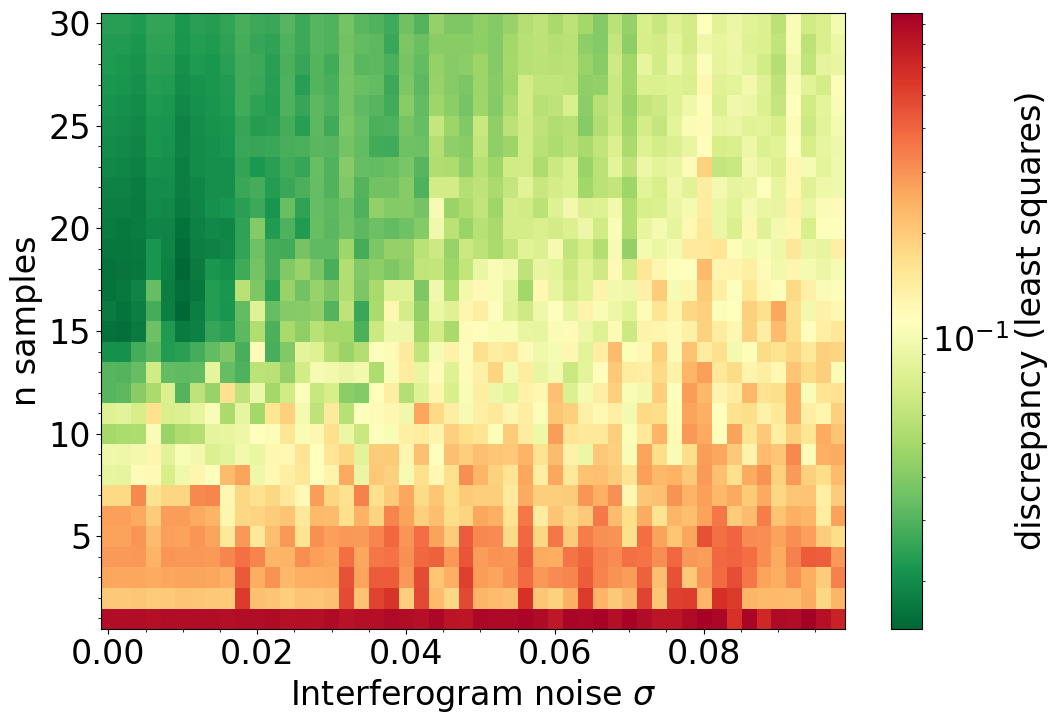

In [8]:
FWHM = 100e9
noises = np.arange(0.0, 0.1, 0.002)
scores2 = np.full((max_samples, len(noises)), np.nan)

for m, noise in tqdm(enumerate(noises)):
    noiseless = cs.generate_interferogram(array_length, pixel_pitch, central_freq, FWHM, theta, read_noise_sigma= 0)
    noise = np.random.normal(0, noise, size= noiseless.shape)
    interferogram = noiseless + noise
    uncertainty = np.full_like(interferogram, noise)

    detectors, _ = cs.douglas_peucker(max_samples, interferogram, uncertainty, noiseless, regularization_coeffient= regularization_coeffient, error_type= "L2")

    for n in range(max_samples):
        scores2[n, m] = cs.evaluate_score(detectors[:n+1], interferogram, uncertainty, noiseless, regularization_coeffient= regularization_coeffient, error_type= "L2")


fig, axs = plt.subplots(1, 1, figsize= (12, 8))

im = axs.imshow(scores2,
                aspect= "auto",
                interpolation= "none",
                norm= "log",
                cmap= "RdYlGn_r",
                extent= ((1.5*noises[0]-0.5*noises[1]), (1.5*noises[-1]-0.5*noises[-2]), 0.5, max_samples +0.5))

axs.set(xlabel= r"Interferogram noise $\sigma$", ylabel= "n samples")

fig.colorbar(im, label= "discrepancy (least squares)")
plt.show()
